In [1]:
import tarfile
import os
import shutil

import numpy as np
import seaborn as sns
from tensorflow import keras
import tensorflow_hub as hub
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import OneHotEncoder

In [2]:
mobilenetv2_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2"
mobilenetv2 = keras.Sequential([hub.KerasLayer(mobilenetv2_url,
                                               input_shape=(224, 224, 3))])

35363/35363 [==============================] - 0s 0us/step


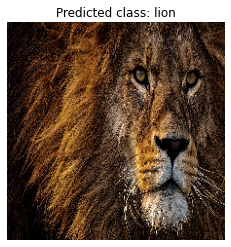

In [3]:
sample_image = keras.preprocessing.image.load_img('/content/Lion.jpg',
                                                  target_size=(224, 224))

# The TF Hub MobileNetV2 expects image pixels normalized between
# 0 and 1.
sample_image = np.array(sample_image) / 255.0

predicted_class = mobilenetv2.predict(np.expand_dims(sample_image, axis=0))
predicted_class = keras.applications.mobilenet_v2.decode_predictions(
    predicted_class[:, 1:], top=1
)
predicted_class = np.ravel(predicted_class)

plt.imshow(sample_image)
plt.title("Predicted class: " + predicted_class[1])
plt.axis('off')
plt.show()

In [4]:
flowers_dataset_path = keras.utils.get_file(
    '/content/flower_photos.tgz',
    origin='https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'
)

tarfile_obj = tarfile.open(flowers_dataset_path)
tarfile_obj.extractall("./")
tarfile_obj.close()

os.mkdir('/content/flower_photos_test')
os.mkdir('/content/flower_photos_test/daisy')
os.mkdir('/content/flower_photos_test/dandelion')
os.mkdir('/content/flower_photos_test/roses')
os.mkdir('/content/flower_photos_test/sunflowers')
os.mkdir('/content/flower_photos_test/tulips')

try:
    os.remove('/content/flower_photos/LICENSE.txt')
except OSError as e:
    print("Error: %s - %s." % (e.filename, e.strerror))

num_samples = 0
for dir_path, dir_names, files in os.walk('/content/flower_photos'):
    num_samples += len(files)

    for file_name in files:
        if np.random.rand(1) < 0.15:
            shutil.move(dir_path[:] + '/' + file_name,
                        dir_path[:22] + "_test" + dir_path[22:] + '/' + file_name)

print("Total number of photos: ", num_samples)

228813984/228813984 [==============================] - 5s 0us/step
Total number of photos:  3670


In [9]:
# Training samples: total number of samples minus 15% for validation.
num_training_samples = num_samples - num_samples * 0.15

# We use 50 batches of 62 images.
batch_size = int(num_training_samples / 50)

# Rescale images to help the model converge faster.
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
    validation_split=0.15
)

# Seed set to 42 for reproducibility.
train_flow = train_datagen.flow_from_directory('/content/flower_photos',
                                               batch_size=batch_size,
                                               target_size=(224, 224),
                                               subset='training',
                                               seed=42)

validation_flow = train_datagen.flow_from_directory('/content/flower_photos',
                                                    batch_size=batch_size,
                                                    target_size=(224, 224),
                                                    subset='validation',
                                                    seed=42)

Found 2650 images belonging to 5 classes.
Found 464 images belonging to 5 classes.


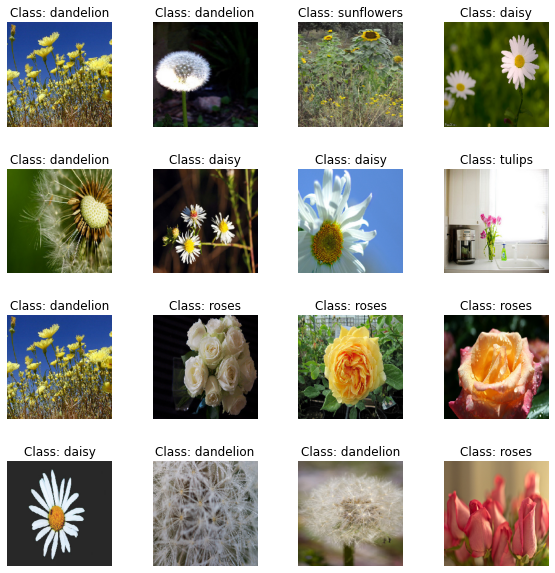

In [10]:
# Get first batch as a dataset sample to use in the grid.
grid_batch = train_flow.__getitem__(0)

# Class names to inverse the one-hot encoding.
labels = np.array(['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'])
labels = labels.reshape(-1, 1)

# Inverse one-hot encoding to plot the actual labels in the grid.
encoder = OneHotEncoder()
encoder.fit(labels)
batch_labels = encoder.inverse_transform(grid_batch[1]).flatten()

# Image grid with 4x4 images.
grid_height = 4
grid_width = 4

fig, axes = plt.subplots(grid_height, grid_width, figsize=(10, 10))
axes = axes.ravel()

for i in range(grid_height * grid_width):
    # Draft random sample from the training set to plot with its label.
    drafted_index = np.random.randint(0, grid_batch[0].shape[0])
    axes[i].imshow(grid_batch[0][drafted_index])
    axes[i].set_title("Class: " + str(batch_labels[drafted_index]))
    axes[i].axis('off')
plt.subplots_adjust(hspace=0.4)

In [27]:
mobilenetv2_feature_extractor = hub.KerasLayer(
    "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2",
    input_shape=(224, 224, 3)
)
feature_batch = mobilenetv2_feature_extractor(train_flow.__getitem__(0)[0])

print("Example output shape from feature extractor: ")
# print(mobilenetv2_feature_extractor
#       .compute_output_shape(train_flow.__getitem__(0)[0].shape))
print(feature_batch.shape)

mobilenetv2_feature_extractor.trainable = False

Example output shape from feature extractor: 
(62, 1280)


In [28]:
mobilenetv2_retrained = keras.Sequential(
    [mobilenetv2_feature_extractor,
     keras.layers.Dense(train_flow.num_classes, activation='softmax')]
)

mobilenetv2_retrained.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_14 (KerasLayer)  (None, 1280)             2257984   
                                                                 
 dense_3 (Dense)             (None, 5)                 6405      
                                                                 
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________
